In [63]:
import math
import random
import numpy as np
import time

import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation as FrameStack
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import NumpyToTorch
from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium.wrappers import RecordVideo

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from operator import itemgetter
import pickle
import os

import ale_py

In [64]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [65]:
frames_stacked = 4

gym.register_envs(ale_py)

game = "ALE/Pong-v5"

terminal_on_life_loss = False
scale_obs = True

env = NumpyToTorch(FrameStack(AtariPreprocessing(RecordEpisodeStatistics(gym.make(game)), frame_skip=1, terminal_on_life_loss=terminal_on_life_loss, scale_obs=scale_obs), frames_stacked), device=device)

num_actions = env.action_space.n
frame_shape = env.observation_space.shape

In [66]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DQN, self).__init__()

        self.input_shape = input_shape
        self.num_outputs = num_outputs

        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        conv_output_len = int(np.prod(self.conv_layers(torch.zeros(1, *input_shape)).size()))

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_len,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256, self.num_outputs)
        )

    def forward(self, x):

        conv_out = self.conv_layers(x)
        return self.fc_layers(conv_out.flatten(1))

In [67]:
args = env.reset()
state = args[0]
input_shape = state.shape

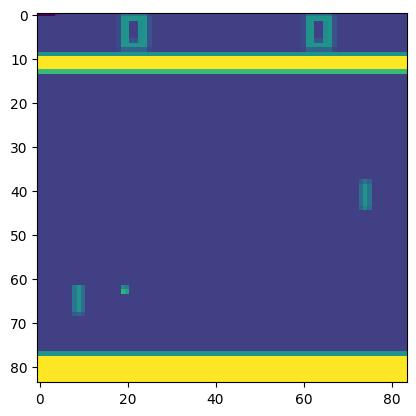

In [68]:
for _ in range(10): state, *_ = env.step(1)
plt.imshow(state[3].cpu().numpy())

In [69]:
model = DQN(input_shape=input_shape, num_outputs=num_actions)

# Create policy and target network.
policy_net = DQN(input_shape=input_shape, num_outputs=num_actions).to(device)
target_net = DQN(input_shape=input_shape, num_outputs=num_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

with torch.no_grad():
    stateValues = policy_net(state.unsqueeze(0))

stateValues

tensor([[-0.0522, -0.0371, -0.0416, -0.0349, -0.0041,  0.0020]])

In [19]:
# Hyperparameters
alpha = 1e-4  # learning rate
gamma = 0.99 # Discount fator

# Optimiser and loss function
optimiser = optim.Adam(policy_net.parameters(), lr=alpha, amsgrad=True)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity, batchSize):
        self.maxCapacity = capacity
        self.stateMemory = []
        self.actionMemory = []
        self.rewardMemory = []
        self.nextStateMemory = []
        self.batchSize = batchSize
        self.currentMemorySize = 0

    def push(self, state, action, reward, nextState):
        self.stateMemory.append(state)
        self.actionMemory.append(action)
        self.rewardMemory.append(reward)
        self.nextStateMemory.append(nextState)

        self.currentMemorySize += 1

        if(self.currentMemorySize > self.maxCapacity):
            self.stateMemory.pop(0)
            self.actionMemory.pop(0)
            self.rewardMemory.pop(0)
            self.nextStateMemory.pop(0)
            self.currentMemorySize -= 1


    def sample(self):
        return random.sample(range(self.currentMemorySize), self.batchSize)

    def replay(self):

        if(self.currentMemorySize < self.batchSize): return

        minibatchIndices = self.sample()

        stateBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.stateMemory))).to(device)
        actionBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.actionMemory))).to(device)
        rewardBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.actionMemory))).to(device).squeeze(1)


        nextStateBatchList = list(itemgetter(*minibatchIndices)(self.nextStateMemory))
        nonFinalNextStates = []
        nonFinalIndices = []

        for s in nextStateBatchList:
            if s is not None:
                nonFinalNextStates.append(s)
                nonFinalIndices.append(True)

            else:
                nonFinalIndices.append(False)

        nonFinalNextStates = torch.cat(nonFinalNextStates).to(device)

        nonFinalNextStateValues = torch.zeros(self.batchSize, device=device)
        nonFinalIndices = torch.tensor(tuple(nonFinalIndices), device=device, dtype=torch.bool)
        policyActions = torch.argmax(policy_net(nonFinalNextStates), dim=1).unsqueeze(1)


        stateActionValues = policy_net(stateBatch).gather(1, actionBatch)

        with torch.no_grad():
            nonFinalNextStateValues[nonFinalIndices] = target_net(nonFinalNextStates).gather(1, policyActions).squeeze(1)

        # Compute the expected Q values
        expected_state_action_values = (nonFinalNextStateValues*gamma) + rewardBatch


        # Compute Huber loss
        optimiser.zero_grad()
        criterion = nn.HuberLoss()

        loss = criterion(stateActionValues, expected_state_action_values.unsqueeze(1))
        #loss.requires_grad = True
        loss.backward()
        # Register backward hook
        for p in policy_net.parameters(): p.grad.data.clamp_(-1, 1)
        optimiser.step()

In [71]:
class PrioritizedReplayMemory(object):

    def __init__(self, capacity, batchSize, alpha=0.6, beta=0.4):
        self.maxCapacity = capacity
        self.stateMemory = []
        self.actionMemory = []
        self.rewardMemory = []
        self.nextStateMemory = []
        self.priorities = []
        self.batchSize = batchSize
        self.currentMemorySize = 0
        
        self.alpha = alpha
        self.beta = beta

    def push(self, state, action, reward, nextState):
        maxPriority = max(self.priorities, default=1.0)
        self.stateMemory.append(state)
        self.actionMemory.append(action)
        self.rewardMemory.append(reward)
        self.nextStateMemory.append(nextState)
        self.priorities.append(maxPriority)

        self.currentMemorySize += 1

        if(self.currentMemorySize > self.maxCapacity):
            self.stateMemory.pop(0)
            self.actionMemory.pop(0)
            self.rewardMemory.pop(0)
            self.nextStateMemory.pop(0)
            self.priorities.pop(0)
            self.currentMemorySize -= 1

    def replay(self):

        if(self.currentMemorySize < self.batchSize): return

        # Compute probabilities
        priorities = np.array(self.priorities, dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample indices based on probabilities
        minibatchIndices = np.random.choice(len(self.stateMemory), self.batchSize, p=probs)
        beta = 0.6
        
        # Compute importance-sampling weights
        total = len(self.stateMemory)
        weights = (total * probs[minibatchIndices]) ** (-beta)
        weights /= weights.max()  # Normalize weights
        weights = torch.tensor(weights, device=device, dtype=torch.float32)
        

        stateBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.stateMemory))).to(device)
        actionBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.actionMemory))).to(device)
        rewardBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.actionMemory))).to(device).squeeze(1)


        nextStateBatchList = list(itemgetter(*minibatchIndices)(self.nextStateMemory))
        nonFinalNextStates = []
        nonFinalIndices = []

        for s in nextStateBatchList:
            if s is not None:
                nonFinalNextStates.append(s)
                nonFinalIndices.append(True)

            else:
                nonFinalIndices.append(False)

        nonFinalNextStates = torch.cat(nonFinalNextStates).to(device)

        nonFinalNextStateValues = torch.zeros(self.batchSize, device=device)
        nonFinalIndices = torch.tensor(tuple(nonFinalIndices), device=device, dtype=torch.bool)
        policyActions = torch.argmax(policy_net(nonFinalNextStates), dim=1).unsqueeze(1)


        stateActionValues = policy_net(stateBatch).gather(1, actionBatch)

        with torch.no_grad():
            nonFinalNextStateValues[nonFinalIndices] = target_net(nonFinalNextStates).gather(1, policyActions).squeeze(1)

        # Compute the expected Q values
        expected_state_action_values = (nonFinalNextStateValues*gamma) + rewardBatch


        # Compute Huber loss
        optimiser.zero_grad()
        criterion = nn.HuberLoss(reduction = 'none')
        print(len(stateActionValues))
        print(len(expected_state_action_values.unsqueeze(1)))
        loss = criterion(stateActionValues, expected_state_action_values.unsqueeze(1))
        #loss.requires_grad = True
        #loss.backward()
        
        
        weighted_loss = (loss * weights.unsqueeze(1)).mean()
        weighted_loss.backward()
        
        # Register backward hook
        for p in policy_net.parameters(): p.grad.data.clamp_(-1, 1)
        optimiser.step()
        
        # Update priorities
        
        td_errors = loss.detach().squeeze().cpu().numpy()
        for i, td_error in zip(minibatchIndices, td_errors):
            self.priorities[i] = abs(td_error) + 1e-5  # Small constant to avoid zero priority

In [61]:
# Replay memory parameters
capacity = 10000
batchSize = 32
#memory = ReplayMemory(capacity=capacity, batchSize=batchSize)
memory = PrioritizedReplayMemory(capacity=capacity, batchSize=batchSize)

In [ ]:
# Resume training

target_net.load_state_dict(torch.load('model_370.pt', map_location=torch.device(device)))
policy_net.load_state_dict(torch.load('model_370.pt', map_location=torch.device(device)))

In [62]:
episodes = 6
verbose = True
steps = 0
verboseEpisode = 5
timesteps = 0
updateEvery = 1000

EPSILON_START=1.0
EPSILON_END=0.02
EPSILON_DECAY=10000

episodeRewards = []
os.makedirs('models', exist_ok=True)
stats = {}

for episode in range(episodes):
  state, _ = env.reset()
  rewards = 0
  terminated, truncated = False, False
  state = state.unsqueeze(0)

  while not terminated and not truncated:

      epsilon = np.interp(steps, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])

      # Explore
      if(random.uniform(0,1) <= epsilon): action = torch.tensor([[env.action_space.sample()]], device=device)

      # Exploit
      else:
          with torch.no_grad():
              q_values = policy_net(state)
              action = torch.argmax(policy_net(state), dim=1).unsqueeze(0)

      steps += 1

      nextState, reward, terminated, truncated, info = env.step(action.item())
      nextState = nextState.unsqueeze(0)

      if(terminated or truncated):
        nextState = None
        stats[episode] = info
      rewards += reward
      memory.push(state, action, torch.tensor([reward], device=device), nextState)


      memory.replay()

      state = nextState

      if(steps%updateEvery == 0): target_net.load_state_dict(policy_net.state_dict())


  episodeRewards.append(rewards)
  if(verbose and episode%verboseEpisode == 0):
    print(f"Episode: {episode}, Current avg reward: {np.mean(episodeRewards[-verboseEpisode:])}")
    torch.save(target_net.state_dict(), 'models/model_'+str(episode)+'.pt')

with open('stats.pkl', 'wb') as f:
  pickle.dump(stats, f)

32
32
32
tensor([[4.0168e+00],
        [2.3234e+00],
        [1.7815e+00],
        [1.7784e+00],
        [7.7073e-01],
        [2.4084e+00],
        [9.1087e-04],
        [9.1087e-04],
        [1.8869e+00],
        [1.8588e+00],
        [3.9774e+00],
        [2.3234e+00],
        [7.8123e-01],
        [2.4084e+00],
        [1.8453e+00],
        [1.8707e+00],
        [2.3234e+00],
        [1.7815e+00],
        [7.7070e-01],
        [1.8852e+00],
        [2.3234e+00],
        [1.8852e+00],
        [7.7073e-01],
        [1.8869e+00],
        [2.3234e+00],
        [1.8316e-04],
        [9.1087e-04],
        [2.6637e-04],
        [2.6637e-04],
        [3.9774e+00],
        [7.7070e-01],
        [1.8869e+00]])
32
32
32
tensor([[4.7499e-04],
        [1.6112e+00],
        [1.6871e+00],
        [7.5965e-04],
        [1.6772e+00],
        [1.6528e+00],
        [3.9225e+00],
        [3.9212e+00],
        [3.8844e+00],
        [3.8858e+00],
        [3.9212e+00],
        [2.2085e+00],
        [1.71

KeyboardInterrupt: 

In [6]:
torch.serialization.register_package(0, lambda x: x.device.type, lambda x, _: x.cpu())

In [72]:
with open('statsDDQN.pkl', 'rb') as f:
  statsDDQN = pickle.load(f)
  
with open('statsRandom.pkl', 'rb') as f:
  statsRandom = pickle.load(f)

with open('statsDQN.pkl', 'rb') as f:
  statsDQN = pickle.load(f)
  
with open('Prioritystats.pkl', 'rb') as f:
  statsPriority = pickle.load(f)

In [73]:
DDQNRewards = []
DDQNLength = []
DQNRewards = []
DQNLength = []
randomRewards = []
randomLength = []
priorityRewards = []
priorityLength = []

for episode in range(len(statsDQN)):
    DDQNRewards.append(statsDDQN[episode]["episode"]['r'].item())
    DDQNLength.append(statsDDQN[episode]["episode"]['t'].item())
    
    DQNRewards.append(statsDQN[episode]["episode"]['r'].item())
    DQNLength.append(statsDQN[episode]["episode"]['t'].item())
    
    randomRewards.append(statsRandom[episode]["episode"]['r'].item())
    randomLength.append(statsRandom[episode]["episode"]['t'].item())
    
    priorityRewards.append(statsPriority[episode]["episode"]['r'].item())
    priorityLength.append(statsPriority[episode]["episode"]['t'].item())

numEpisodes = len(DDQNRewards)

print("Trained for", numEpisodes, "Episodes...")

Trained for 2001 Episodes...


In [ ]:

randomRewards = []
randomStats = {}
episodes = 2001
env = RecordEpisodeStatistics(gym.make(game))

for episode in range(episodes):
    state, _ = env.reset()
    rewards = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        # Explore
        action = torch.tensor([[env.action_space.sample()]], device=device)
        
        steps += 1
        nextState, reward, terminated, truncated, info = env.step(action.item())
        
        if(terminated or truncated):
            randomStats[episode] = info
        rewards += reward

    randomRewards.append(rewards)

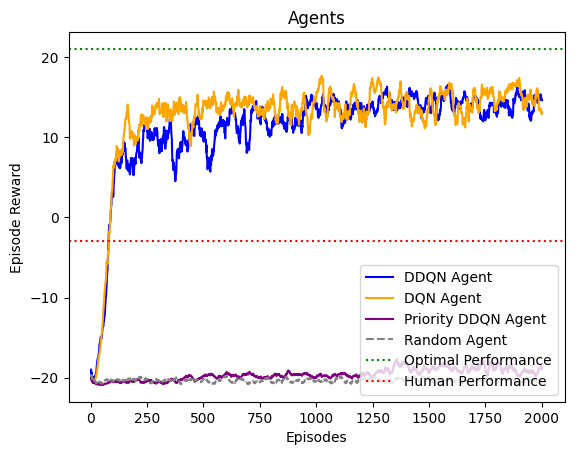

In [77]:
MARange = 20
MADDQNRewards = [np.mean(DDQNRewards[max(i-MARange, 0):i]) for i in range(len(DDQNRewards))]
MADQNRewards = [np.mean(DQNRewards[max(i-MARange, 0):i]) for i in range(len(DQNRewards))]
MARandom = [np.mean(randomRewards[max(i-MARange, 0):i]) for i in range(len(randomRewards))]
MAPriority = [np.mean(priorityRewards[max(i-MARange, 0):i]) for i in range(len(priorityRewards))]


plt.plot(range(1,len(MADDQNRewards)+1),MADDQNRewards, color = 'b', label="DDQN Agent")
plt.plot(range(1,len(MADQNRewards)+1),MADQNRewards, color = 'orange', label="DQN Agent")
plt.plot(range(1,len(MAPriority)+1),MAPriority, color = 'purple', label="Priority DDQN Agent")
plt.plot(range(1,len(MARandom)+1),MARandom, color = 'gray', linestyle = 'dashed', label="Random Agent")
plt.axhline(y = 21.0, xmin= 0, color = 'g', linestyle = ':', label = "Optimal Performance")
plt.axhline(y = -3.0, xmin= 0, color = 'r', linestyle = ':', label = "Human Performance") 
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
#plt.title(str('Agent MA('+str(MARange)+')'))
plt.title("Agents")
plt.legend(loc="lower right")
plt.show()

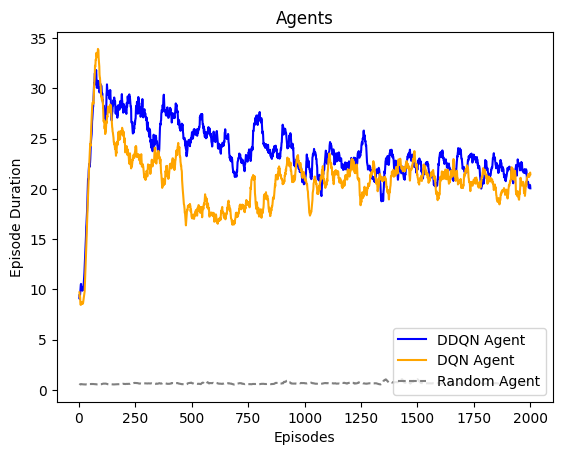

In [10]:

MARange = 20
MADDQNDuration= [np.mean(DDQNLength[max(i-MARange, 0):i]) for i in range(len(DDQNLength))]
MADQNDuration = [np.mean(DQNLength[max(i-MARange, 0):i]) for i in range(len(DQNLength))]
MARandomDuration = [np.mean(randomLength[max(i-MARange, 0):i]) for i in range(len(randomLength))]

plt.plot(range(1,len(MADDQNDuration)+1),MADDQNDuration, color = 'b', label="DDQN Agent")
plt.plot(range(1,len(MADQNDuration)+1),MADQNDuration, color = 'orange', label="DQN Agent")
plt.plot(range(1,len(MARandomDuration)+1),MARandomDuration, color = 'gray', linestyle = 'dashed', label="Random Agent")
plt.xlabel('Episodes')
plt.legend(loc="lower right")
plt.ylabel('Episode Duration')
#plt.title(str('Agent MA('+str(MARange)+')'))
plt.title("Agents")
plt.legend(loc="lower right")
plt.show()

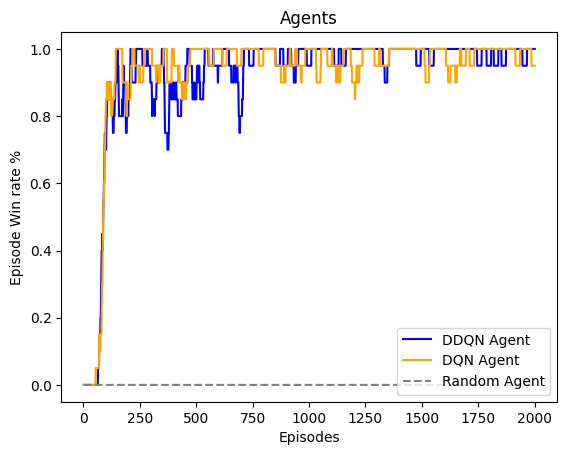

In [11]:
MARange = 20
DDQNOutcome = [1 if(DDQNRewards[i] > 0) else 0 for i in range(len(DDQNRewards))]
DQNOutcome  = [1 if(DQNRewards[i] > 0) else 0  for i in range(len(DQNRewards))]
RandomOutcome  = [1 if(randomRewards[i] > 0) else 0 for i in range(len(randomRewards))]

MADDQNWinRate = [np.mean(DDQNOutcome[max(i-MARange, 0):i]) for i in range(len(DDQNLength))]
MADQNWinRate = [np.mean(DQNOutcome[max(i-MARange, 0):i]) for i in range(len(DQNLength))]
MARandomWinRate = [np.mean(RandomOutcome[max(i-MARange, 0):i]) for i in range(len(randomLength))]


plt.plot(range(1,len(MADDQNWinRate)+1),MADDQNWinRate, color = 'b', label="DDQN Agent")
plt.plot(range(1,len(MADQNWinRate)+1),MADQNWinRate, color = 'orange', label="DQN Agent")
plt.plot(range(1,len(MARandomWinRate )+1),MARandomWinRate , color = 'gray', linestyle = 'dashed', label="Random Agent")
plt.xlabel('Episodes')
plt.ylabel('Episode Win rate %')
#plt.title(str('Agent MA('+str(MARange)+')'))
plt.title("Agents")
plt.legend(loc="lower right")
plt.show()

In [ ]:
model1 = DQN(input_shape=input_shape, num_outputs=num_actions)
model1.load_state_dict(torch.load('DDQN_2000.pt', map_location=torch.device(device)))
model1.eval()

C:\Users\joshu\AppData\Local\Temp\ipykernel_29928\438209085.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2000.pt', map_locatio

DQN(
  (conv_layers): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [ ]:
model2 = DQN(input_shape=input_shape, num_outputs=num_actions)
model2.load_state_dict(torch.load('DQN_2000.pt', map_location=torch.device(device)))
model2.eval()

In [53]:
# Evaluate the trained agent
env = NumpyToTorch(FrameStack(AtariPreprocessing(gym.make(game, render_mode='rgb_array'), frame_skip=1, terminal_on_life_loss=terminal_on_life_loss, scale_obs=scale_obs), frames_stacked), device=device)
total_rewards = []
num_episodes_eval = 100
for _ in range(num_episodes_eval):
    state = env.reset()[0]
    rewards = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        action = torch.argmax(model(state.unsqueeze(0))).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        rewards += reward

    total_rewards.append(rewards)

print(f"Average Total Reward (Evaluation): {np.mean(total_rewards)}")

Average Total Reward (Evaluation): 15.06


# Watch Agent!

In [20]:
# watch trained agent
env = RecordVideo(gym.make(game, render_mode='rgb_array'), "")
env = NumpyToTorch(FrameStack(AtariPreprocessing(env, frame_skip=1, terminal_on_life_loss=terminal_on_life_loss, scale_obs=scale_obs), frames_stacked), device=device)


state = env.reset()[0]

rewards = 0
terminated, truncated = False, False
steps = 0

while not terminated and not truncated:

    action = torch.argmax(model(state.unsqueeze(0))).item()

    next_state, reward, terminated, truncated, info = env.step(action)
    state = next_state

    rewards += reward

print("Total Reward: ", rewards)
time.sleep(3)
env.close()

c:\Users\joshu\anaconda3\envs\rl\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\joshu\OneDrive\Documents\GitHub\Q-learningAgents folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Total Reward:  -21.0


In [ ]:
env.close()